In [ ]:
#Downgrade numpy to a compatible version to make sure that pandas-ta works because it doesn't work with the newest version of numpy atm
!pip install numpy==1.24.3 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have nump

In [ ]:
!pip install alpaca-trade-api
#this is just for the historical bars
!pip install alpaca-py pandas ta python-dotenv
!pip install ta
!pip install pandas-ta
!pip install mplfinance
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.6 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.3-cp311-cp311-linux_x86_64.whl size=15688 sha256=531e328ac2a3bc7869f1cd1b29b360cd673d311ce1acbe606646753cb38e375b
  Stored in directory: /root/.cache/pip/wheels/f6/35/da/ed9b26b510235e00e3a3c3bab7bad97b59214729662255ab3d
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.1
    Uninstalling msgpack-1.1.1:
      Successfully uninstalled msgpack-1.1.1
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling 

In [ ]:
import alpaca_trade_api as tradeapi
import os
from datetime import datetime, timedelta
import pandas as pd
from dotenv import load_dotenv
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import timedelta
import numpy as np

In [ ]:
import joblib

# Load the trained machine learning model
model = joblib.load('HMMRSI_MODEL.pkl')
scaler = joblib.load('HMMRSI_SCALER.pkl')

In [ ]:
# Load the trained HMM model and scaler
hmm_model = joblib.load('hidden_markov_model.pkl')

In [ ]:
API_KEY = "your api key"
SECRET_KEY = "your key"
BASE_URL = 'https://paper-api.alpaca.markets'  # For paper trading or use live URL for real trading

api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')
#Initialize Alpaca Historical Data Client
client = StockHistoricalDataClient(
    api_key=API_KEY,
    secret_key=SECRET_KEY
)
# Config
symbol = "SPY"
timeframe = TimeFrame.Minute  # <- This sets 5-minute intervals
lookback_days = 4 # number of days you wanna look back
# Pull historical bars
start_date = datetime.today() - timedelta(days=lookback_days)
request_params = StockBarsRequest(
    symbol_or_symbols=symbol,
    timeframe=timeframe,
    start=start_date
)
bars = client.get_stock_bars(request_params).df
df = bars[bars.index.get_level_values(0) == symbol].copy().reset_index()
df.rename(columns={"timestamp": "datetime"}, inplace=True)

df = df.resample('5min', on='datetime').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna().reset_index()
#Ensure 'datetime' column is datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
#Set datetime as the index (important for VWAP)
df.set_index('datetime', inplace=True)
#Sort the DataFrame by datetime to ensure it is ordered
df.sort_index(inplace=True)
# Convert from UTC to US/Eastern timezone
df.index = df.index.tz_convert('US/Eastern')

In [ ]:
import ta
# Calculate RSI
rsi_window = 14
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=rsi_window).rsi()

In [ ]:
#HMM FEATURES
df['return'] = df['close'].pct_change()
df['volatility'] = df['return'].rolling(10).std()

In [ ]:
import pandas_ta as ta
#this section is where you have your features

In [ ]:
# Make a clean copy
df = df.copy()

# Drop rows where features have NaNs
df_clean = df.dropna(subset=['return', 'volatility'])

# Extract features for prediction
y = df_clean[['return', 'volatility']].values

# Predict states for clean data only
states = hmm_model.predict(y)

# Assign predictions to the correct subset's index
df.loc[df_clean.index, 'hmm_state'] = states

In [ ]:
features_used = [
    #features
]
# Select the necessary columns from your DataFrame
X = df[features_used]  # Make sure this matches the training features
X = X.dropna()  # Drop any rows with missing values
# If you need to scale the features, use the same scaler that was used during training
from sklearn.preprocessing import StandardScaler
# Fit the scaler on the training data and transform the data
X_scaled = scaler.fit_transform(X)  # Only fit the scaler once on the training set
# Predict reversals using the trained model
predictions = model.predict(X_scaled)
# Optionally, if you want probabilities for a better analysis
probabilities = model.predict_proba(X_scaled)  # Get probability scores for each class
# Add predictions to your dataframe
df['prediction'] = predictions
print(df['prediction'].value_counts(3))
print(df[['close', 'prediction']].tail(100))

prediction
0    0.751987
1    0.241653
2    0.006359
Name: proportion, dtype: float64
                             close  prediction
datetime                                      
2025-07-03 04:15:00-04:00  621.280           0
2025-07-03 04:20:00-04:00  621.190           0
2025-07-03 04:25:00-04:00  621.300           0
2025-07-03 04:30:00-04:00  621.150           0
2025-07-03 04:35:00-04:00  621.300           0
...                            ...         ...
2025-07-03 12:20:00-04:00  625.730           0
2025-07-03 12:25:00-04:00  625.735           0
2025-07-03 12:30:00-04:00  625.920           0
2025-07-03 12:35:00-04:00  625.960           0
2025-07-03 12:40:00-04:00  626.170           0

[100 rows x 2 columns]


Plotting 2025-06-30


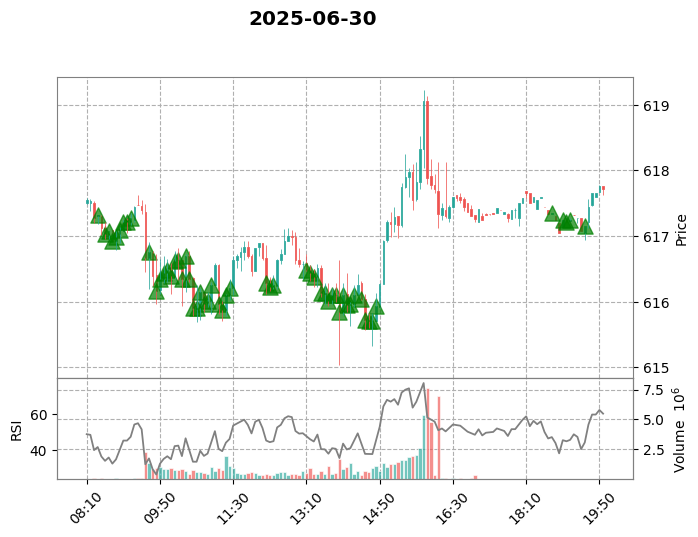

Plotting 2025-07-01


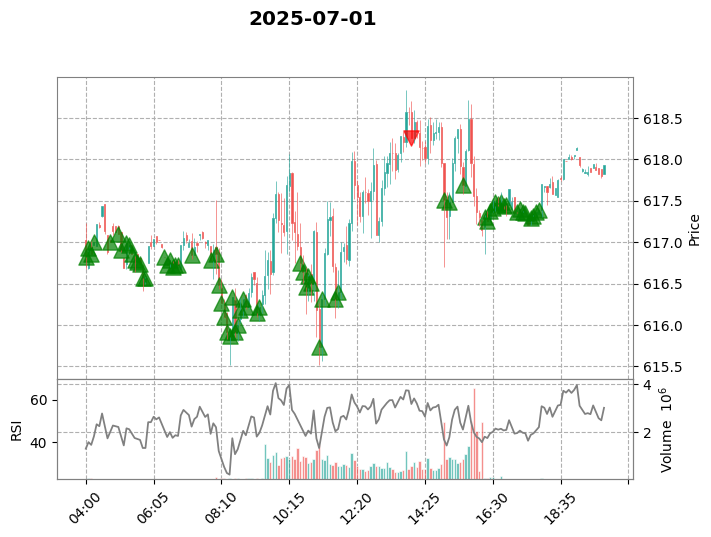

Plotting 2025-07-02


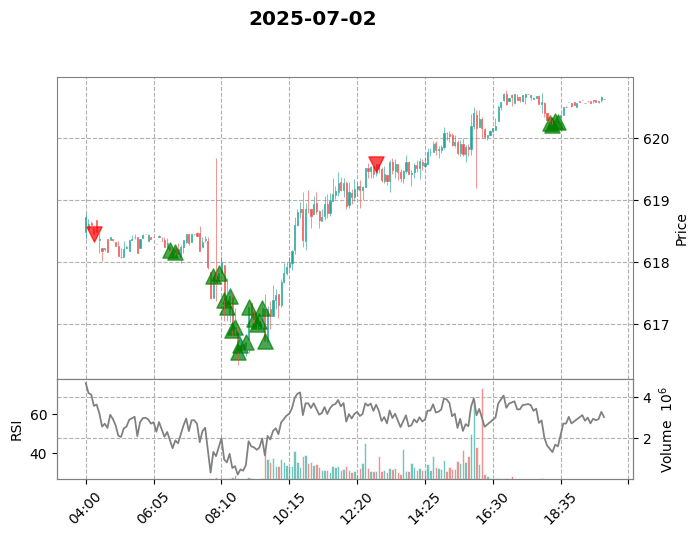

Plotting 2025-07-03


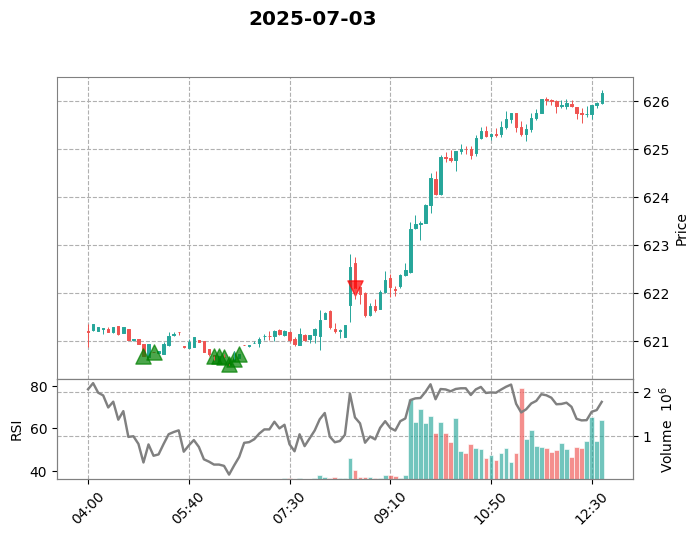

In [ ]:
import numpy as np
import pandas as pd
import mplfinance as mpf

# Make sure index is datetime
df.index = pd.to_datetime(df.index)

# Extract just the dates (no time)
df['date_only'] = df.index.date

# Loop through each unique trading day
for trading_date in df['date_only'].unique():
    df_day = df[df['date_only'] == trading_date].copy()

    # Skip if not enough data to plot candles
    if len(df_day) < 2:
        continue

    # Create aligned markers for that day
    buy_marker = pd.Series([np.nan] * len(df_day), index=df_day.index)
    sell_marker = pd.Series([np.nan] * len(df_day), index=df_day.index)

    buy_marker[df_day['prediction'] == 1] = df_day.loc[df_day['prediction'] == 1, 'close']
    sell_marker[df_day['prediction'] == 2] = df_day.loc[df_day['prediction'] == 2, 'close']

    # Add buy/sell scatter plots
    add_plots = []
    if buy_marker.dropna().size > 0:
        add_plots.append(mpf.make_addplot(buy_marker, type='scatter', marker='^', markersize=120, color='green',alpha=0.7))
    if sell_marker.dropna().size > 0:
        add_plots.append(mpf.make_addplot(sell_marker, type='scatter', marker='v', markersize=120, color='red',alpha=0.7))

    # Add RSI line plot in a separate panel below
    if 'rsi' in df_day.columns:
        add_plots.append(mpf.make_addplot(df_day['rsi'], panel=1, color='grey', ylabel='RSI'))

    # Plot each day in a separate chart with RSI subplot
    print(f"Plotting {trading_date}")
    mpf.plot(df_day, type='candle', volume=True, style='tradingview',
             addplot=add_plots, title=f'{trading_date}',
             panel_ratios=(6,2),  # Makes RSI panel shorter
             warn_too_much_data=500)
